In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import os

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

DATASET_PATH = "dataset"
TRAIN_FILE = os.path.join(DATASET_PATH, "emnist-byclass-train.csv")
TEST_FILE = os.path.join(DATASET_PATH, "emnist-byclass-test.csv")
MAPPING_FILE = os.path.join(DATASET_PATH, "emnist-byclass-mapping.txt")

In [19]:
def load_emnist_byclass():
    # Загружаем тренировочные и тестовые данные
    train_data = pd.read_csv(TRAIN_FILE)
    test_data = pd.read_csv(TEST_FILE)
    
    # Маппинг классов (номера к символам)
    # Формат: номер_класса ASCII_код
    mapping = pd.read_csv(MAPPING_FILE, 
                          sep=' ', 
                          header=None, 
                          names=['class', 'ascii'])
    
    print(f"Тренировочные данные: {train_data.shape}")
    print(f"Тестовые данные: {test_data.shape}")
    print(f"Количество классов: {len(mapping)}")
    print(f"Пример маппинга:\n{mapping.head(10)}")
    
    return train_data, test_data, mapping

# Загрузка данных
train_data, test_data, mapping = load_emnist_byclass()

Тренировочные данные: (697931, 785)
Тестовые данные: (116322, 785)
Количество классов: 62
Пример маппинга:
   class  ascii
0      0     48
1      1     49
2      2     50
3      3     51
4      4     52
5      5     53
6      6     54
7      7     55
8      8     56
9      9     57


In [ ]:
def prepare_emnist_data(train_data, test_data):
    X_train = train_data.iloc[:, 1:].values
    y_train = train_data.iloc[:, 0].values
    X_test = test_data.iloc[:, 1:].values
    y_test = test_data.iloc[:, 0].values
    print(f"   X_train shape: {X_train.shape}")
    print(f"   y_train shape: {y_train.shape}")

    X_train = X_train.reshape(-1, 28, 28, 1)  #(все строки, 28 на 28, 1 канал)
    X_test = X_test.reshape(-1, 28, 28, 1)

    X_train = np.transpose(X_train, (0, 2, 1, 3))
    X_test = np.transpose(X_test, (0, 2, 1, 3))

    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    
    num_classes = 62
    y_train_cat = keras.utils.to_categorical(y_train, num_classes)
    y_test_cat = keras.utils.to_categorical(y_test, num_classes)
    
    print(f"   После преобразования:")
    print(f"   X_train shape: {X_train.shape}")
    print(f"   y_train_cat shape: {y_train_cat.shape}")
    
    return X_train, X_test, y_train_cat, y_test_cat, y_train, y_test

X_train, X_test, y_train_cat, y_test_cat, y_train, y_test = prepare_emnist_data(train_data, test_data)

   X_train shape: (697931, 784)
   y_train shape: (697931,)
   После преобразования:
   X_train shape: (697931, 28, 28, 1)
   y_train_cat shape: (697931, 62)


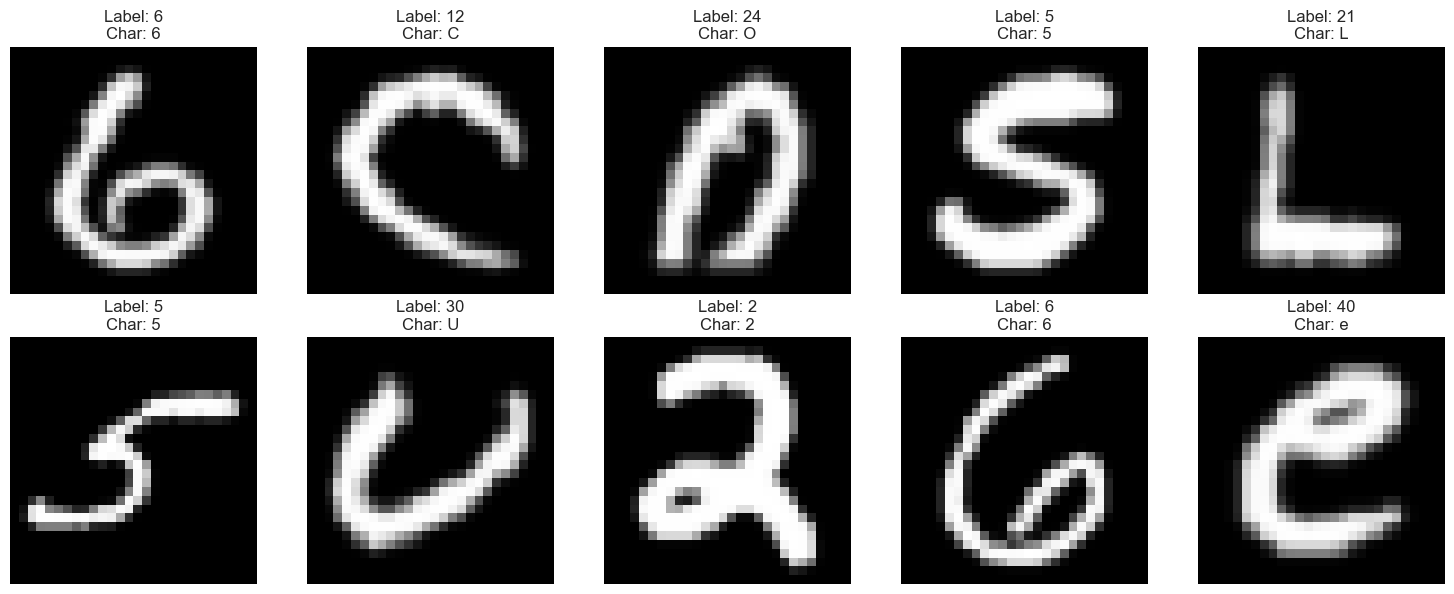

In [29]:
def show_samples(X, y, mapping):
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    
    for i in range(10):
        idx = np.random.randint(0, len(X))
        
        axes[i].imshow(X[idx].reshape(28, 28), cmap='gray')
        
        label = y[idx]
        ascii_code = mapping.loc[mapping['class'] == label, 'ascii'].values[0]
        char = chr(ascii_code)
        
        axes[i].set_title(f'Label: {label}\nChar: {char}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

show_samples(X_train, y_train, mapping)

In [34]:
def create_cnn_model(input_shape=(28, 28, 1), num_classes=62):
    model = keras.Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        
        # Второй сверточный слой
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Всего один полносвязный слой
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(62, activation='softmax')
    ])
    
    return model

# Создаем модель
model = create_cnn_model()
model.summary()

c:\ulstu\4\СИИ\model\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 62)             │         4,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,094 (234.74 KB)

 Trainable params: 60,094 (234.74 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [36]:
from sklearn.model_selection import train_test_split

# Разделяем тренировочные данные на train/validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train_cat, 
    test_size=0.2, 
    random_state=42,
    stratify=y_train  # сохраняем пропорции классов
)

print(f"Размеры:")
print(f"  X_train_split: {X_train_split.shape}")
print(f"  X_val: {X_val.shape}")

history = model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val, y_val),
    epochs=30,  # можно начать с 30 эпох
    batch_size=64,
    verbose=1
)

Размеры:
  X_train_split: (558344, 28, 28, 1)
  X_val: (139587, 28, 28, 1)
Epoch 1/30
8725/8725 ━━━━━━━━━━━━━━━━━━━━ 94s 10ms/step - accuracy: 0.7555 - loss: 0.7841 - val_accuracy: 0.8363 - val_loss: 0.4704
Epoch 2/30
8725/8725 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - accuracy: 0.8143 - loss: 0.5547 - val_accuracy: 0.8475 - val_loss: 0.4350
Epoch 3/30
8725/8725 ━━━━━━━━━━━━━━━━━━━━ 93s 11ms/step - accuracy: 0.8256 - loss: 0.5148 - val_accuracy: 0.8505 - val_loss: 0.4207
Epoch 4/30
8725/8725 ━━━━━━━━━━━━━━━━━━━━ 98s 11ms/step - accuracy: 0.8314 - loss: 0.4934 - val_accuracy: 0.8544 - val_loss: 0.4097
Epoch 5/30
8725/8725 ━━━━━━━━━━━━━━━━━━━━ 130s 10ms/step - accuracy: 0.8349 - loss: 0.4790 - val_accuracy: 0.8554 - val_loss: 0.4068
Epoch 6/30
8725/8725 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - accuracy: 0.8376 - loss: 0.4695 - val_accuracy: 0.8560 - val_loss: 0.4035
Epoch 7/30
8725/8725 ━━━━━━━━━━━━━━━━━━━━ 86s 10ms/step - accuracy: 0.8398 - loss: 0.4615 - val_accuracy: 0.8558 - val_loss: 0.4037
Ep

C:\Users\pasha\AppData\Local\Temp\ipykernel_31800\1964309139.py:36: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\pasha\AppData\Local\Temp\ipykernel_31800\1964309139.py:36: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.tight_layout()


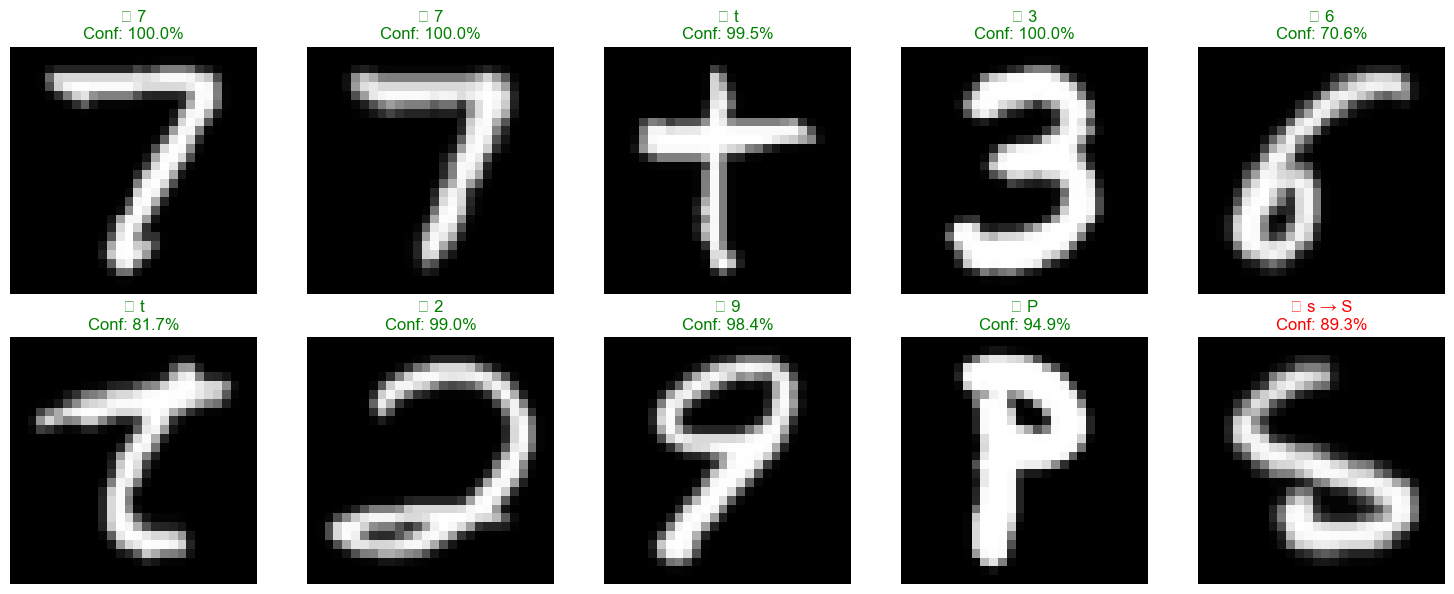

Правильно распознано: 9/10 (90.0%)


In [38]:
def test_random_predictions(model, X_test, y_test, mapping, n=10):
    
    # Выбираем случайные индексы
    indices = np.random.choice(len(X_test), n, replace=False)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    
    correct = 0
    predictions = []
    
    for i, idx in enumerate(indices):
        img = X_test[idx]
        true_label = y_test[idx]
        
        # Предсказание
        pred_proba = model.predict(img[np.newaxis, ...], verbose=0)
        pred_label = np.argmax(pred_proba)
        
        # Получаем символы
        true_char = chr(mapping.loc[mapping['class'] == true_label, 'ascii'].values[0])
        pred_char = chr(mapping.loc[mapping['class'] == pred_label, 'ascii'].values[0])
        
        # Отображаем
        axes[i].imshow(img.reshape(28, 28), cmap='gray')
        
        if true_label == pred_label:
            axes[i].set_title(f'✓ {true_char}\nConf: {pred_proba[0][pred_label]:.1%}', color='green')
            correct += 1
        else:
            axes[i].set_title(f'✗ {true_char} → {pred_char}\nConf: {pred_proba[0][pred_label]:.1%}', color='red')
        
        axes[i].axis('off')
        predictions.append((true_char, pred_char, pred_proba[0][pred_label]))
    
    plt.tight_layout()
    plt.show()
    
    print(f"Правильно распознано: {correct}/{n} ({correct/n:.1%})")
    return predictions

# Тестируем
predictions = test_random_predictions(model, X_test, y_test, mapping, 10)

In [40]:
# Сохранение модели в формате .keras
model.save('models/CNN_model_86%_acc.keras')

# Сохранение маппинга для использования в приложении
mapping.to_csv('models/emnist_mapping.csv', index=False)
print("Маппинг сохранен как 'emnist_mapping.csv'")

Маппинг сохранен как 'emnist_mapping.csv'


Модель загружена: models/CNN_model_improver.keras
Входной размер: (None, 28, 28, 1)
Выходных классов: 62
Найден маппинг CSV: models/emnist_mapping.csv
Маппинг загружен. Классов: 62
['tests\\test.png', 'tests\\test2.png', 'tests\\test3.png', 'tests\\test4.png', 'tests\\test5.png']
Найдено изображений: 5

ИЗОБРАЖЕНИЕ 1/5: test.png

ОБРАБОТКА ИЗОБРАЖЕНИЯ: tests\test.png

✅ Выделено символов: 26
✅ Количество строк: 3


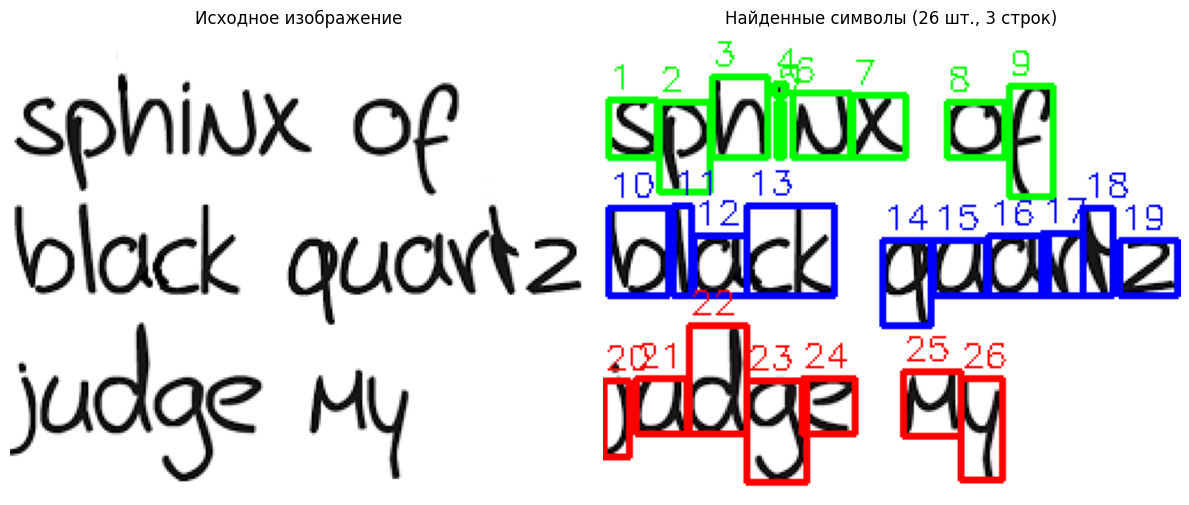


Распознавание 26 символов...
  Символ 1 (строка 1): 'S' (уверенность: 87.2%)
  Символ 2 (строка 1): 'P' (уверенность: 69.0%)
  Символ 3 (строка 1): 'h' (уверенность: 81.3%)
  Символ 4 (строка 1): 'i' (уверенность: 57.6%)
  Символ 5 (строка 1): 'I' (уверенность: 40.0%)
  Символ 6 (строка 1): 'N' (уверенность: 96.7%)
  Символ 7 (строка 1): 'x' (уверенность: 71.5%)
  Символ 8 (строка 1): 'O' (уверенность: 49.1%)
  Символ 9 (строка 1): 'F' (уверенность: 29.6%)
  Символ 10 (строка 2): 'b' (уверенность: 88.4%)
  Символ 11 (строка 2): 'l' (уверенность: 41.3%)
  Символ 12 (строка 2): 'a' (уверенность: 82.2%)
  Символ 13 (строка 2): 'd' (уверенность: 98.9%)
  Символ 14 (строка 2): '9' (уверенность: 80.6%)
  Символ 15 (строка 2): 'U' (уверенность: 83.6%)
  Символ 16 (строка 2): 'a' (уверенность: 74.1%)
  Символ 17 (строка 2): 'x' (уверенность: 35.5%)
  Символ 18 (строка 2): 'I' (уверенность: 38.4%)
  Символ 19 (строка 2): '2' (уверенность: 67.7%)
  Символ 20 (строка 3): 'I' (уверенность: 34.6%)

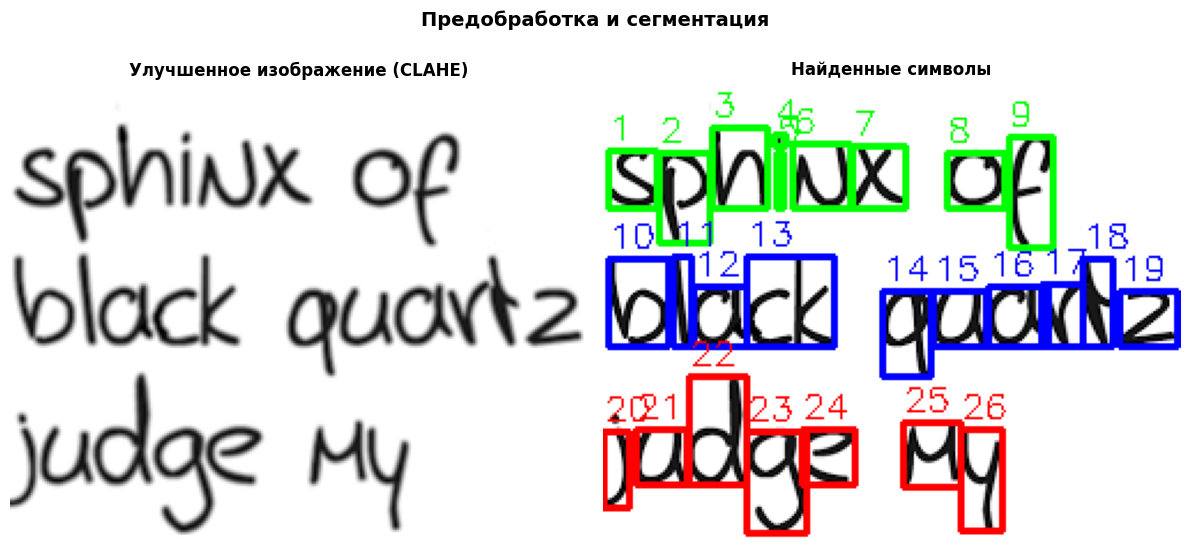

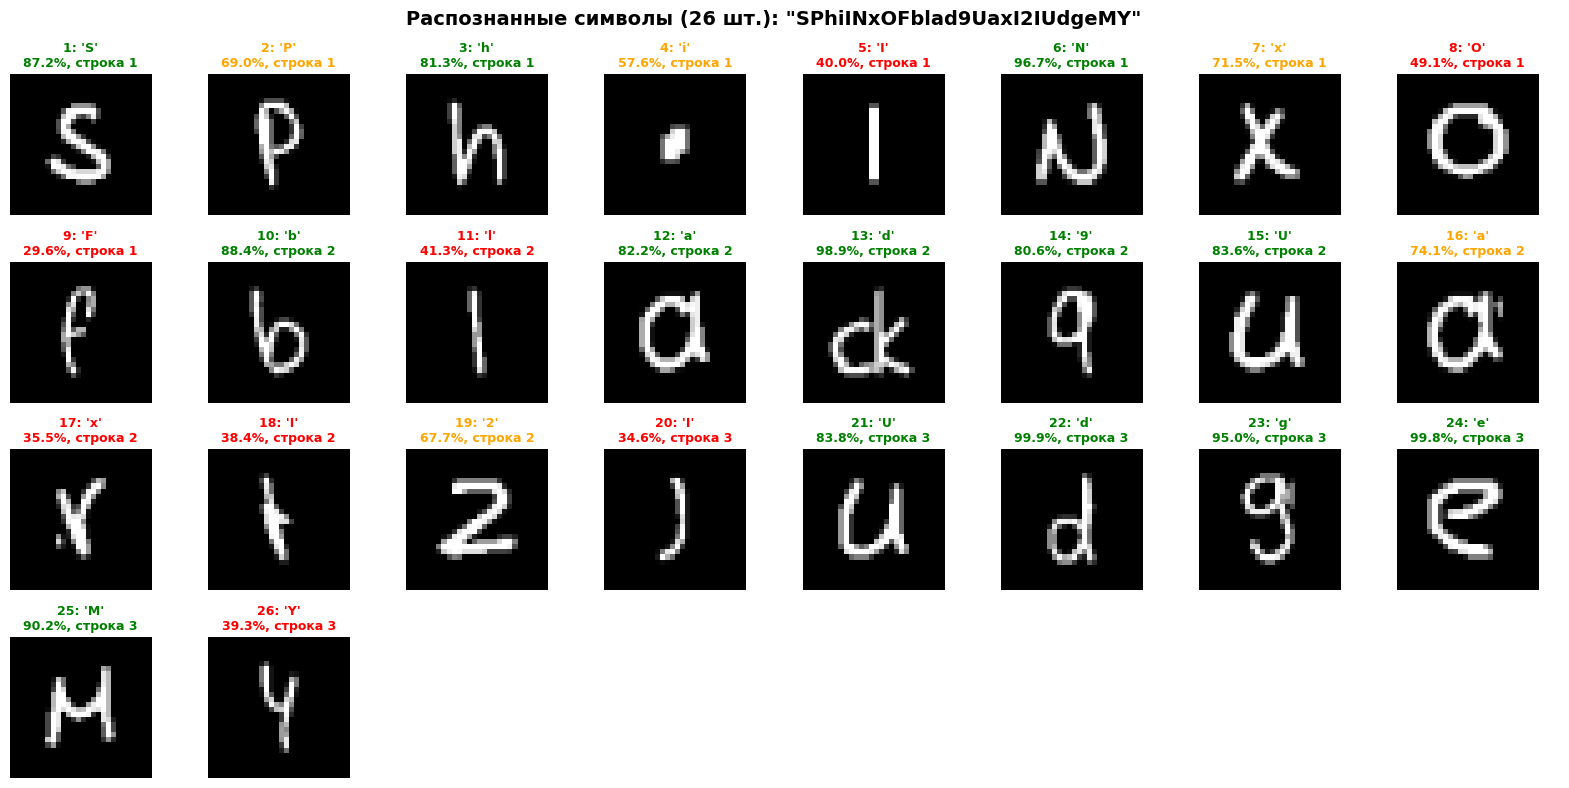


СВОДНАЯ ИНФОРМАЦИЯ:
Всего символов: 26
Количество строк: 3

Текст по строкам:
----------------------------------------
Строка 1: SPhiI NxOF
Строка 2: blad9 UaxI2
Строка 3: IUdge MY
----------------------------------------

Статистика уверенности:
  Средняя уверенность: 69.82%
  Высокая уверенность (>80%): 13 симв.
  Средняя уверенность (50-80%): 5 симв.
  Низкая уверенность (<50%): 8 симв.

РАСПОЗНАННЫЙ ТЕКСТ:
----------------------------------------
SPhiINxOF
blad9UaxI2
IUdgeMY
----------------------------------------
Статистика: 26 символов, 3 строк, уверенность: 69.82%
ИЗОБРАЖЕНИЕ 2/5: test2.png

ОБРАБОТКА ИЗОБРАЖЕНИЯ: tests\test2.png

✅ Выделено символов: 55
✅ Количество строк: 7


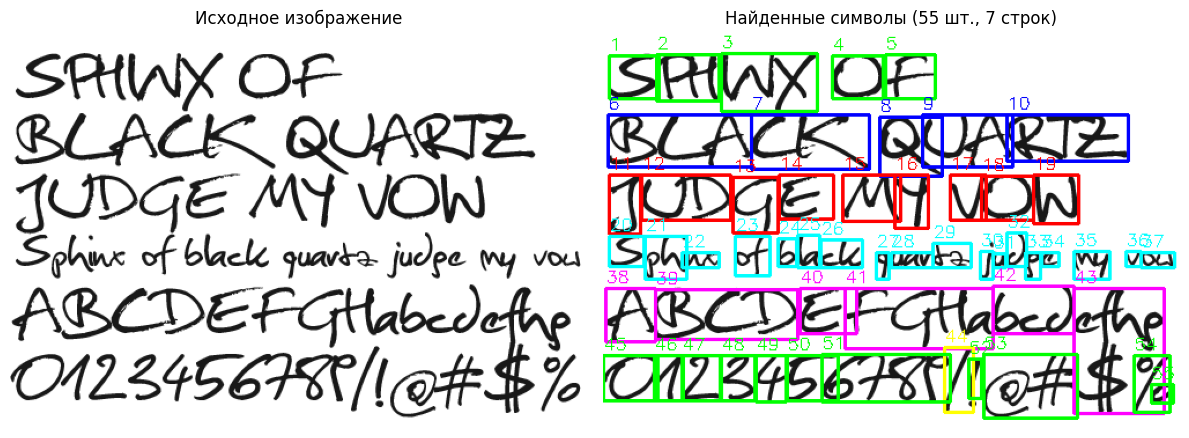


Распознавание 55 символов...
  Символ 1 (строка 1): 'S' (уверенность: 85.6%)
  Символ 2 (строка 1): 'M' (уверенность: 78.0%)
  Символ 3 (строка 1): 'w' (уверенность: 46.6%)
  Символ 4 (строка 1): '0' (уверенность: 52.2%)
  Символ 5 (строка 1): 'F' (уверенность: 74.9%)
  Символ 6 (строка 2): 'w' (уверенность: 56.0%)
  Символ 7 (строка 2): '4' (уверенность: 82.2%)
  Символ 8 (строка 2): '8' (уверенность: 63.4%)
  Символ 9 (строка 2): 'w' (уверенность: 65.6%)
  Символ 10 (строка 2): 'a' (уверенность: 50.1%)
  Символ 11 (строка 3): 'J' (уверенность: 48.6%)
  Символ 12 (строка 3): 'w' (уверенность: 71.3%)
  Символ 13 (строка 3): '9' (уверенность: 75.2%)
  Символ 14 (строка 3): 'E' (уверенность: 99.3%)
  Символ 15 (строка 3): 'M' (уверенность: 80.3%)
  Символ 16 (строка 3): 'Y' (уверенность: 58.3%)
  Символ 17 (строка 3): 'U' (уверенность: 43.2%)
  Символ 18 (строка 3): '0' (уверенность: 52.9%)
  Символ 19 (строка 3): 'W' (уверенность: 70.3%)
  Символ 20 (строка 4): 'S' (уверенность: 78.8%)

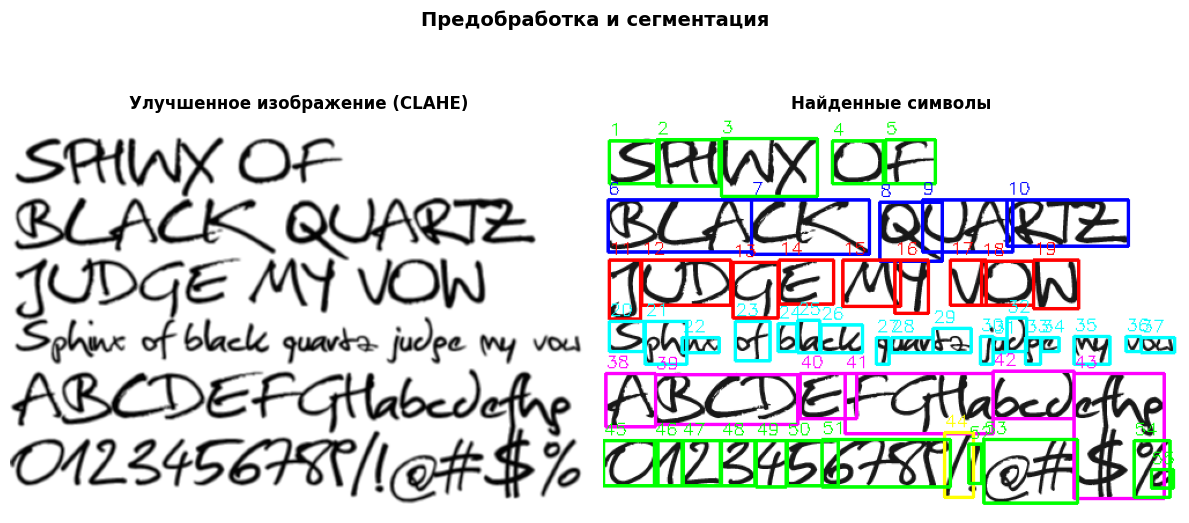

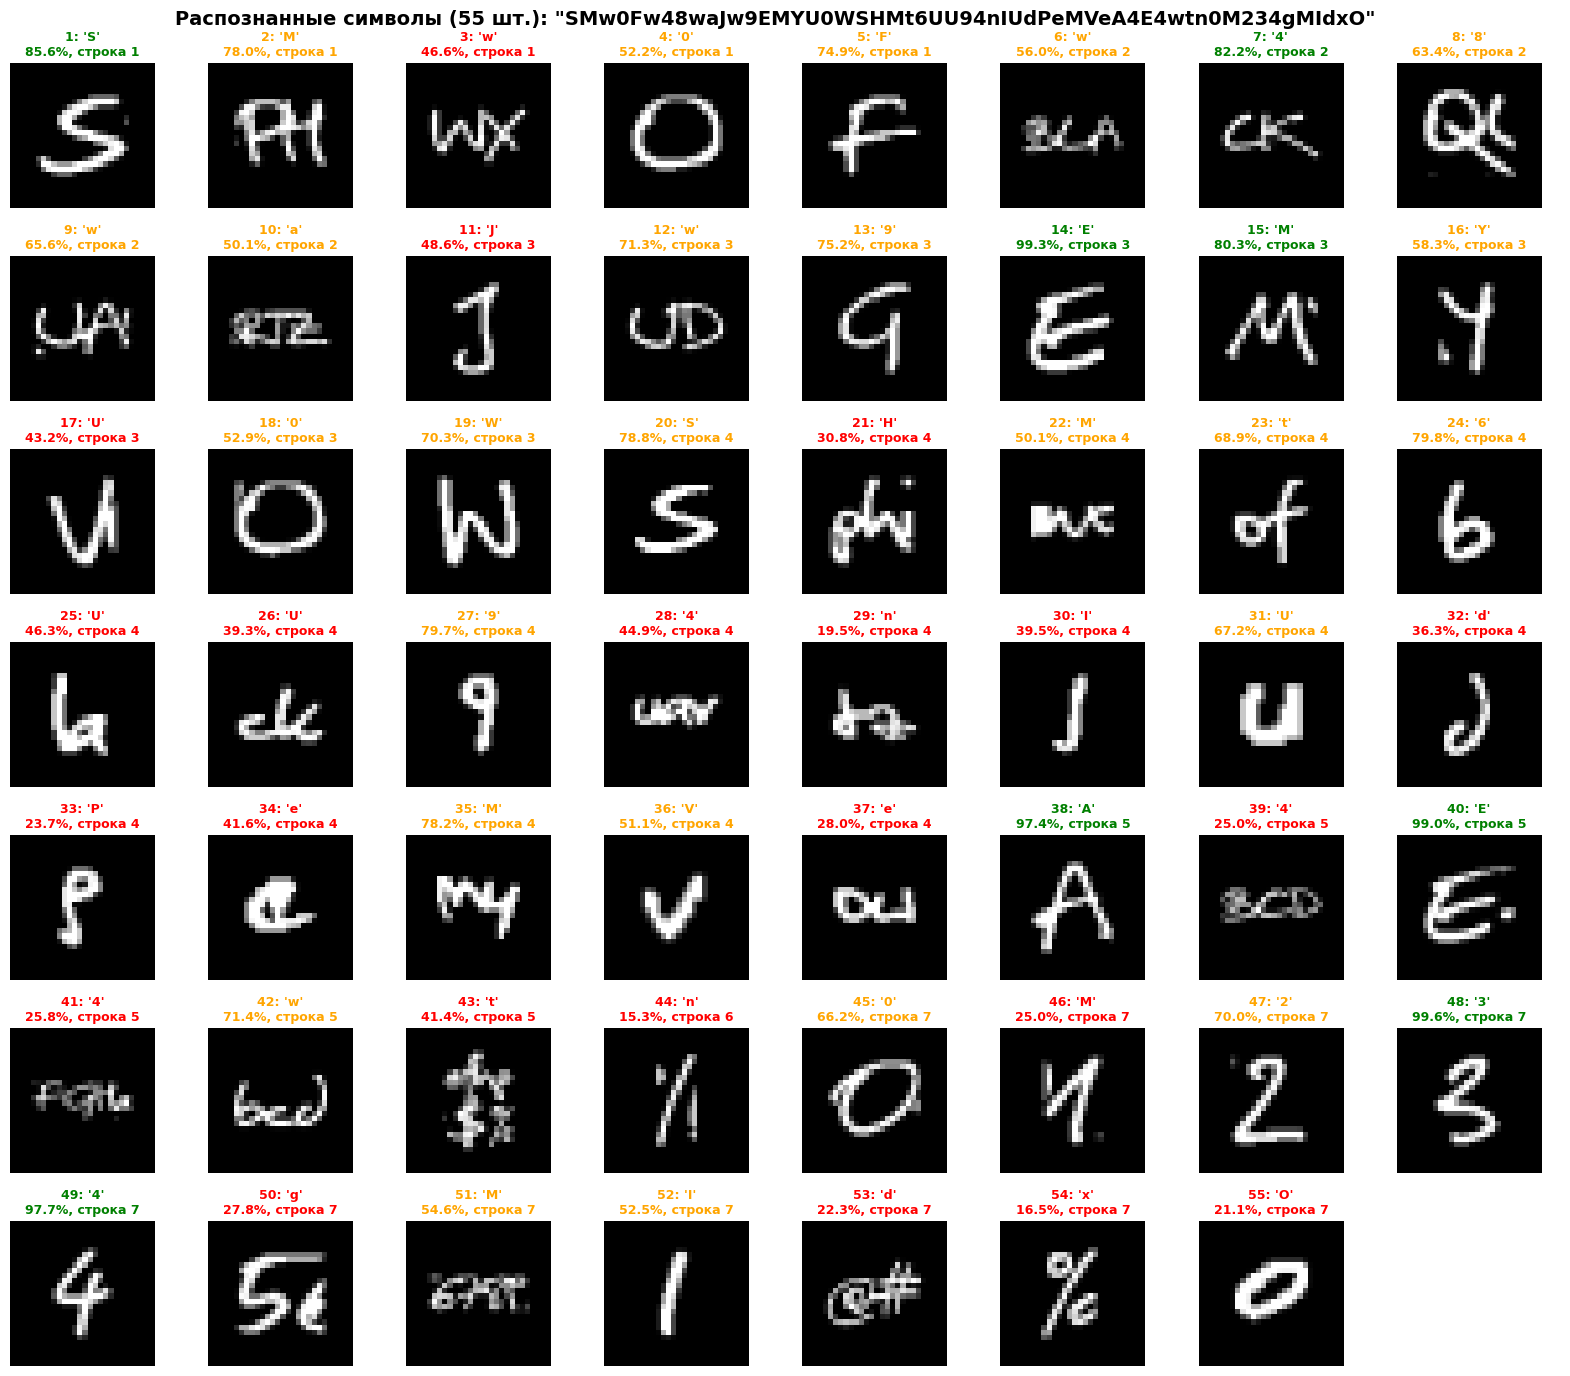


СВОДНАЯ ИНФОРМАЦИЯ:
Всего символов: 55
Количество строк: 7

Текст по строкам:
----------------------------------------
Строка 1: SMw0F
Строка 2: w48wa
Строка 3: Jw9EM YU0W
Строка 4: SHMt6 UU94n IUdPe MVe
Строка 5: A4E4w t
Строка 6: n
Строка 7: 0M234 gMIdx O
----------------------------------------

Статистика уверенности:
  Средняя уверенность: 56.12%
  Высокая уверенность (>80%): 8 симв.
  Средняя уверенность (50-80%): 25 симв.
  Низкая уверенность (<50%): 22 симв.

РАСПОЗНАННЫЙ ТЕКСТ:
----------------------------------------
SMw0F
w48wa
Jw9EMYU0W
SHMt6UU94nIUdPeMVe
A4E4wt
n
0M234gMIdxO
----------------------------------------
Статистика: 55 символов, 7 строк, уверенность: 56.12%
ИЗОБРАЖЕНИЕ 3/5: test3.png

ОБРАБОТКА ИЗОБРАЖЕНИЯ: tests\test3.png

✅ Выделено символов: 8
✅ Количество строк: 1


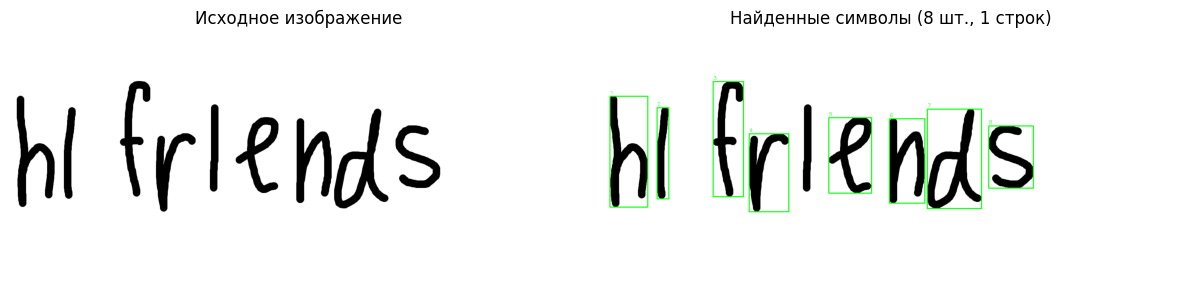


Распознавание 8 символов...
  Символ 1 (строка 1): 'h' (уверенность: 97.0%)
  Символ 2 (строка 1): 'l' (уверенность: 51.4%)
  Символ 3 (строка 1): 't' (уверенность: 23.4%)
  Символ 4 (строка 1): 'r' (уверенность: 99.1%)
  Символ 5 (строка 1): 'e' (уверенность: 71.2%)
  Символ 6 (строка 1): 'M' (уверенность: 53.8%)
  Символ 7 (строка 1): 'd' (уверенность: 99.9%)
  Символ 8 (строка 1): 'S' (уверенность: 78.2%)

РЕЗУЛЬТАТ:
  Текст (с пробелами и строками):
  ----------------------------------------
  hltreMdS
  ----------------------------------------
  Средняя уверенность: 71.8%
  Символов: 8
  Строк: 1


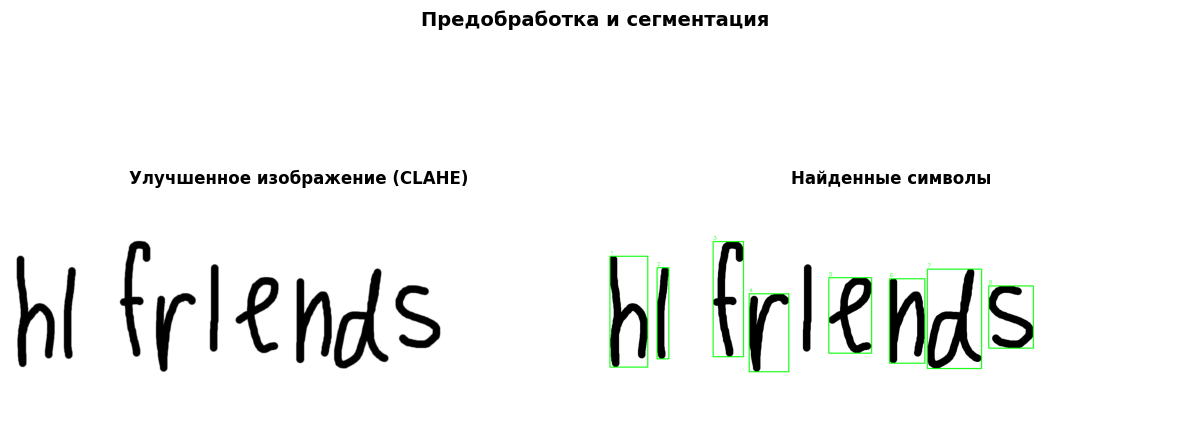

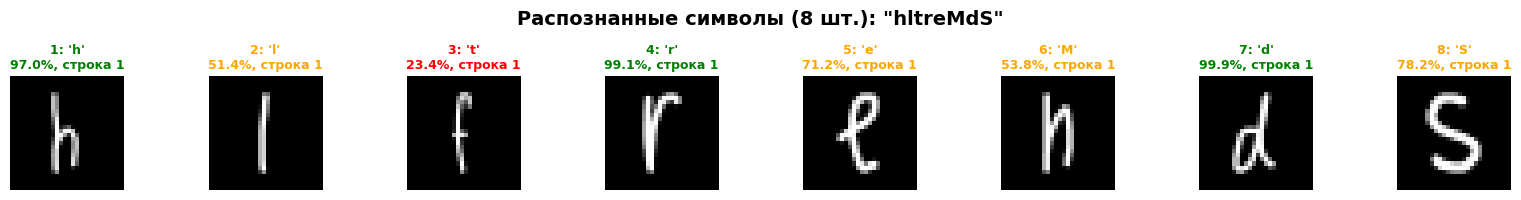


СВОДНАЯ ИНФОРМАЦИЯ:
Всего символов: 8
Количество строк: 1

Текст по строкам:
----------------------------------------
Строка 1: hltre MdS
----------------------------------------

Статистика уверенности:
  Средняя уверенность: 71.76%
  Высокая уверенность (>80%): 3 симв.
  Средняя уверенность (50-80%): 4 симв.
  Низкая уверенность (<50%): 1 симв.

РАСПОЗНАННЫЙ ТЕКСТ:
----------------------------------------
hltreMdS
----------------------------------------
Статистика: 8 символов, 1 строк, уверенность: 71.76%
ИЗОБРАЖЕНИЕ 4/5: test4.png

ОБРАБОТКА ИЗОБРАЖЕНИЯ: tests\test4.png

✅ Выделено символов: 19
✅ Количество строк: 2


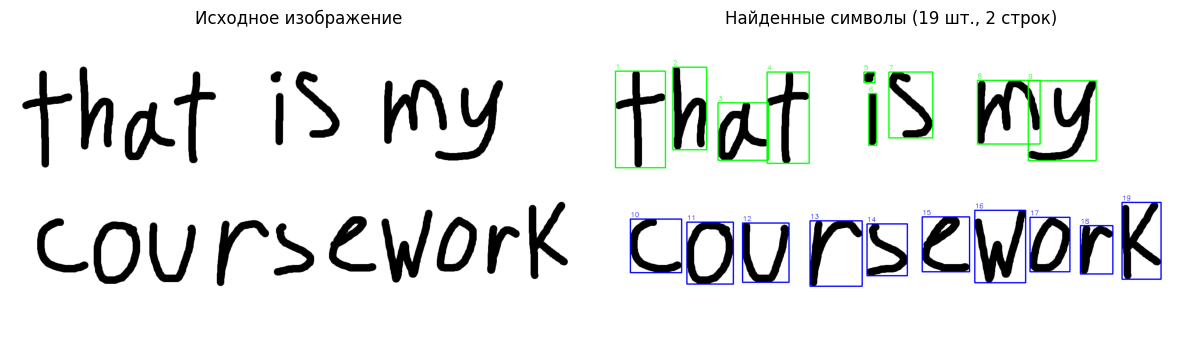


Распознавание 19 символов...
  Символ 1 (строка 1): 't' (уверенность: 94.0%)
  Символ 2 (строка 1): 'h' (уверенность: 97.7%)
  Символ 3 (строка 1): 'a' (уверенность: 55.7%)
  Символ 4 (строка 1): 't' (уверенность: 85.5%)
  Символ 5 (строка 1): 'O' (уверенность: 60.0%)
  Символ 6 (строка 1): 'I' (уверенность: 38.1%)
  Символ 7 (строка 1): '5' (уверенность: 48.4%)
  Символ 8 (строка 1): 'M' (уверенность: 86.1%)
  Символ 9 (строка 1): 'y' (уверенность: 79.2%)
  Символ 10 (строка 2): 'C' (уверенность: 73.4%)
  Символ 11 (строка 2): '0' (уверенность: 71.0%)
  Символ 12 (строка 2): 'U' (уверенность: 92.0%)
  Символ 13 (строка 2): 'r' (уверенность: 100.0%)
  Символ 14 (строка 2): 'S' (уверенность: 63.1%)
  Символ 15 (строка 2): 'e' (уверенность: 84.7%)
  Символ 16 (строка 2): 'W' (уверенность: 73.1%)
  Символ 17 (строка 2): '0' (уверенность: 68.8%)
  Символ 18 (строка 2): 'r' (уверенность: 100.0%)
  Символ 19 (строка 2): 'K' (уверенность: 72.3%)

РЕЗУЛЬТАТ:
  Текст (с пробелами и строками):


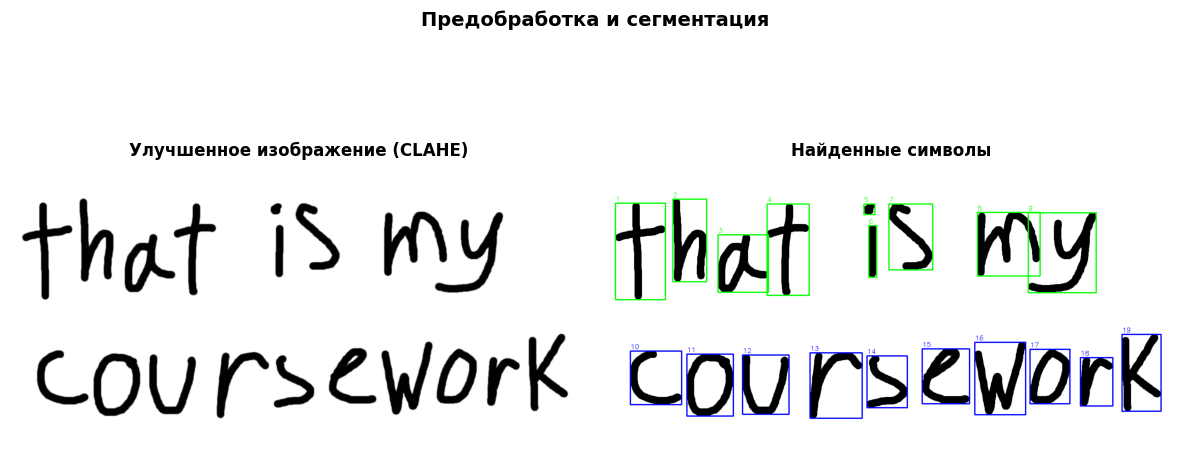

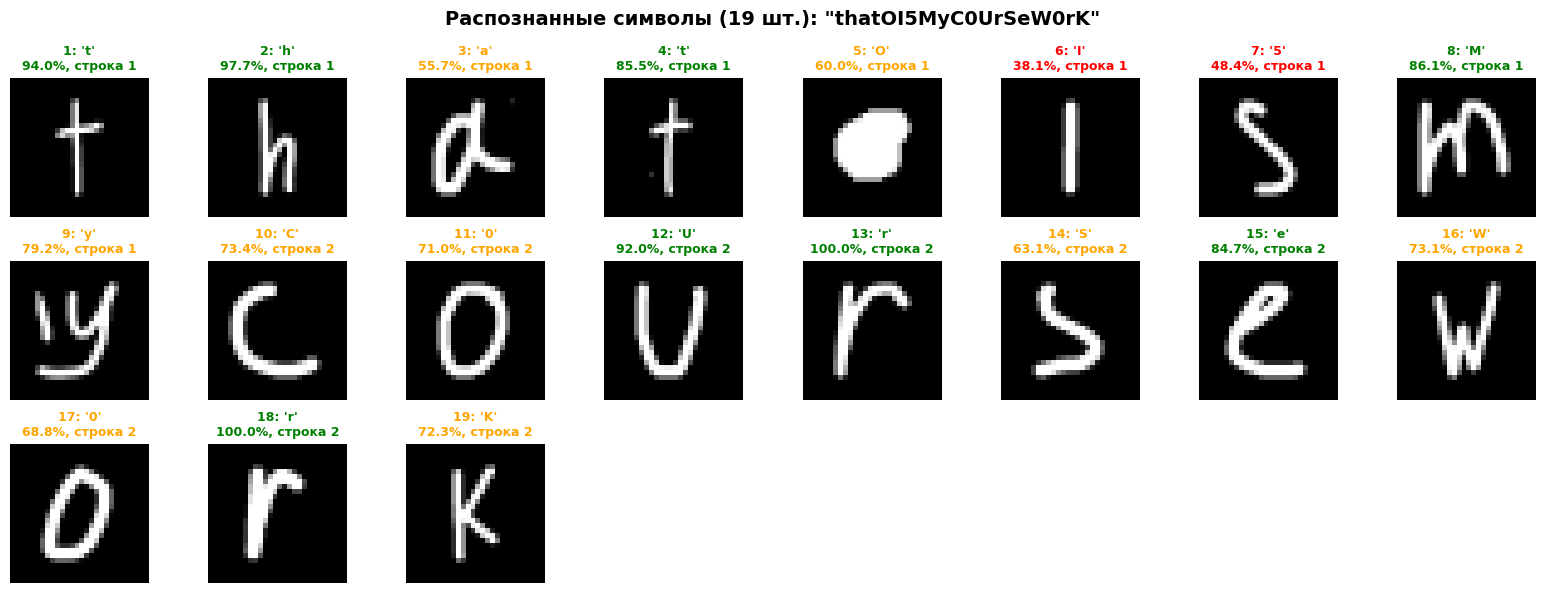


СВОДНАЯ ИНФОРМАЦИЯ:
Всего символов: 19
Количество строк: 2

Текст по строкам:
----------------------------------------
Строка 1: thatO I5My
Строка 2: C0UrS eW0rK
----------------------------------------

Статистика уверенности:
  Средняя уверенность: 75.94%
  Высокая уверенность (>80%): 8 симв.
  Средняя уверенность (50-80%): 9 симв.
  Низкая уверенность (<50%): 2 симв.

РАСПОЗНАННЫЙ ТЕКСТ:
----------------------------------------
thatOI5My
C0UrSeW0rK
----------------------------------------
Статистика: 19 символов, 2 строк, уверенность: 75.94%
ИЗОБРАЖЕНИЕ 5/5: test5.png

ОБРАБОТКА ИЗОБРАЖЕНИЯ: tests\test5.png

✅ Выделено символов: 10
✅ Количество строк: 2


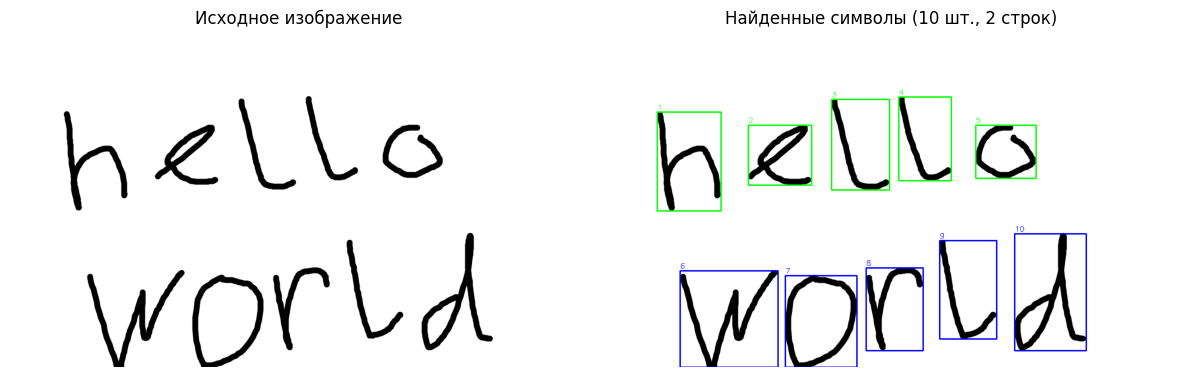


Распознавание 10 символов...
  Символ 1 (строка 1): 'h' (уверенность: 98.1%)
  Символ 2 (строка 1): 'R' (уверенность: 97.0%)
  Символ 3 (строка 1): 'L' (уверенность: 57.8%)
  Символ 4 (строка 1): 'L' (уверенность: 66.5%)
  Символ 5 (строка 1): '0' (уверенность: 64.1%)
  Символ 6 (строка 2): 'W' (уверенность: 81.1%)
  Символ 7 (строка 2): '0' (уверенность: 75.7%)
  Символ 8 (строка 2): 'r' (уверенность: 98.5%)
  Символ 9 (строка 2): 'l' (уверенность: 27.2%)
  Символ 10 (строка 2): 'd' (уверенность: 97.6%)

РЕЗУЛЬТАТ:
  Текст (с пробелами и строками):
  ----------------------------------------
  hRLL0
W0rld
  ----------------------------------------
  Средняя уверенность: 76.3%
  Символов: 10
  Строк: 2


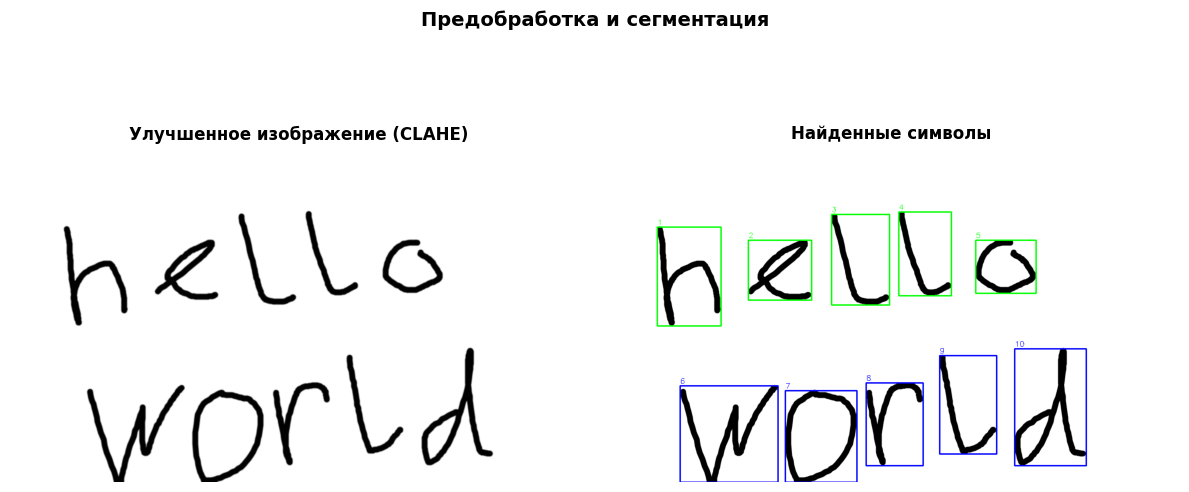

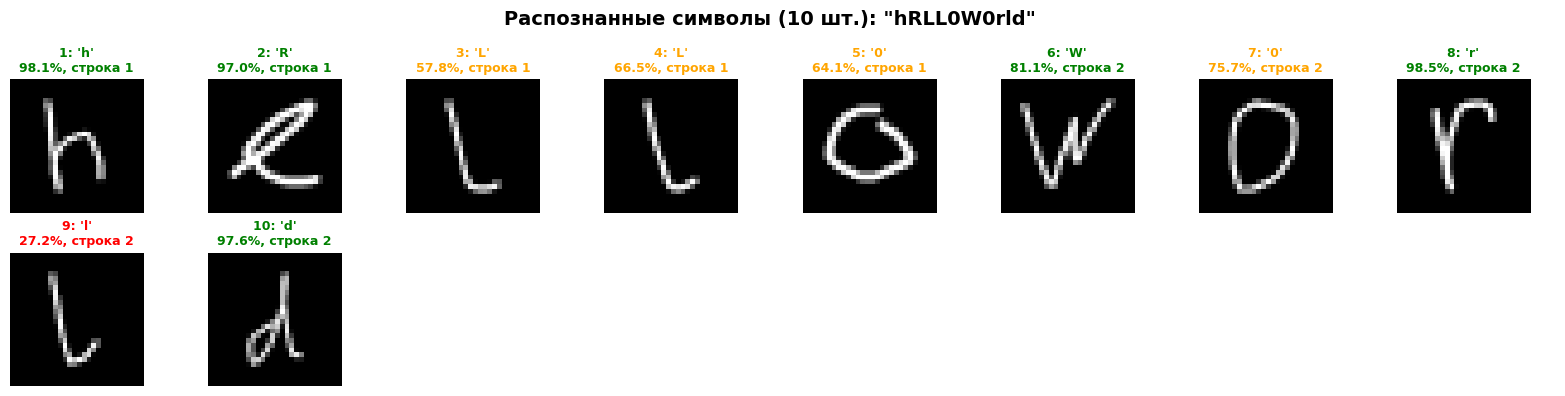


СВОДНАЯ ИНФОРМАЦИЯ:
Всего символов: 10
Количество строк: 2

Текст по строкам:
----------------------------------------
Строка 1: hRLL0
Строка 2: W0rld
----------------------------------------

Статистика уверенности:
  Средняя уверенность: 76.35%
  Высокая уверенность (>80%): 5 симв.
  Средняя уверенность (50-80%): 4 симв.
  Низкая уверенность (<50%): 1 симв.

РАСПОЗНАННЫЙ ТЕКСТ:
----------------------------------------
hRLL0
W0rld
----------------------------------------
Статистика: 10 символов, 2 строк, уверенность: 76.35%

Обработка завершена. Всего обработано: 5 изображений


In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from tensorflow import keras
from collections import defaultdict

class TextRecognitionSystem:
    def __init__(self, model_path='models/CNN_model_86%_acc.keras', mapping_path='models/char_mapping.json'):
        
        # 1. Загружаем модель
        if not os.path.exists(model_path):
            print(f"Ошибка: Модель не найдена по пути: {model_path}")
            model_path_h5 = model_path.replace('.keras', '.h5')
            if os.path.exists(model_path_h5):
                print(f"Найдена модель .h5: {model_path_h5}")
                model_path = model_path_h5
            else:
                raise FileNotFoundError(f"Модель не найдена: {model_path}")
        
        self.model = keras.models.load_model(model_path)
        print(f"Модель загружена: {model_path}")
        print(f"Входной размер: {self.model.input_shape}")
        print(f"Выходных классов: {self.model.output_shape[1]}")
        
        # 2. Загружаем маппинг
        self.char_mapping = self.load_mapping(mapping_path)
        print(f"Маппинг загружен. Классов: {len(self.char_mapping)}")
        
        # 3. Параметры для определения пробелов и строк
        self.space_threshold_factor = 1.5  # Во сколько раз расстояние должно быть больше среднего для пробела
        self.line_threshold_factor = 1.2   # Во сколько раз расстояние по Y должно быть больше для новой строки
        self.supported_formats = ['.jpg', '.jpeg', '.png', '.bmp', '.JPG', '.JPEG', '.PNG', '.BMP']
    
    def load_mapping(self, mapping_path):
        """Загрузка маппинга с обработкой разных форматов"""
        char_mapping = {}
        
        if not os.path.exists(mapping_path):
            mapping_path_csv = 'models/emnist_mapping.csv'
            if os.path.exists(mapping_path_csv):
                print(f"Найден маппинг CSV: {mapping_path_csv}")
                mapping_df = pd.read_csv(mapping_path_csv)
                for _, row in mapping_df.iterrows():
                    char_mapping[int(row['class'])] = chr(int(row['ascii']))
            else:
                raise FileNotFoundError(f"Маппинг не найден: {mapping_path}")
        else:
            if mapping_path.endswith('.csv'):
                mapping_df = pd.read_csv(mapping_path)
                for _, row in mapping_df.iterrows():
                    if 'class' in row and 'ascii' in row:
                        char_mapping[int(row['class'])] = chr(int(row['ascii']))
            elif mapping_path.endswith('.json'):
                with open(mapping_path, 'r', encoding='utf-8') as f:
                    char_mapping = json.load(f)
                    # Преобразуем строковые ключи в int при необходимости
                    char_mapping = {int(k) if k.isdigit() else k: v for k, v in char_mapping.items()}
        
        return char_mapping
    
    def validate_image(self, image_path):
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Файл не найден: {image_path}")
        
        file_ext = os.path.splitext(image_path)[1].lower()
        if file_ext not in self.supported_formats:
            raise ValueError(f"Неподдерживаемый формат: {file_ext}. "
                           f"Поддерживаемые: {', '.join(self.supported_formats)}")
        
        file_size_mb = os.path.getsize(image_path) / (1024 * 1024)
        if file_size_mb > 10:
            raise ValueError(f"Файл слишком большой: {file_size_mb:.1f} МБ. "
                           f"Максимум: 10 МБ")
        
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError("Не удалось загрузить изображение. Возможно, файл поврежден.")
        
        return img
    
    def preprocess_for_emnist(self, image):
        """Приведение изображения символа к формату EMNIST"""
        # 1. Убедимся, что это одноканальное изображение
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # 2. Применяем пороговую обработку, белый текст на черном фоне
        _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        # 3. Находим контуры символа
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            # Берем самый большой контур
            contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(contour)
            
            # Вырезаем символ
            char_region = thresh[y:y+h, x:x+w]
            
            # Добавляем отступы
            padding = 4
            char_with_padding = cv2.copyMakeBorder(char_region, padding, padding, padding, padding, 
                                                 cv2.BORDER_CONSTANT, value=0)
            
            # Масштабируем до 20x20 с сохранением соотношения сторон
            new_size = 20
            h, w = char_with_padding.shape
            scale = min(new_size/h, new_size/w)
            new_h, new_w = int(h * scale), int(w * scale)
            resized = cv2.resize(char_with_padding, (new_w, new_h), interpolation=cv2.INTER_AREA)
            
            # Помещаем в центр изображения 28x28
            final_image = np.zeros((28, 28), dtype=np.uint8)
            
            # Координаты для размещения в центре
            y_offset = (28 - new_h) // 2
            x_offset = (28 - new_w) // 2
            final_image[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
            
            # Нормализуем
            final_image = final_image.astype('float32') / 255.0
            
            return final_image.reshape(28, 28, 1)
        else:
            # Если контуров нет
            return np.zeros((28, 28, 1), dtype='float32')
    
    def segment_text(self, image_path):
        img = self.validate_image(image_path)

        # 1. Преобразуем в оттенки серого
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img.copy()
        
        gray = cv2.GaussianBlur(gray, (3, 3), 0)
            
        # 2. Улучшение контраста
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(gray)

        # 3. Бинаризация
        binary = cv2.adaptiveThreshold(enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

        # 4. Удаление шумов
        denoised = cv2.medianBlur(binary, 3)

        # 5. Морфологические операции
        kernel_erode = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
        eroded = cv2.erode(denoised, kernel_erode, iterations=1)

        # Заполнение дырок
        contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        filled = np.zeros_like(eroded)

        for cnt in contours:
            cv2.drawContours(filled, [cnt], -1, 255, -1)

        kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 2))
        processed = cv2.erode(filled, kernel_open, iterations=1)

        # 6. Находим контуры символов
        contours, _ = cv2.findContours(processed, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        
        # Фильтрация по вложению
        filtered_contours = []
        for i, cnt1 in enumerate(contours):
            x1, y1, w1, h1 = cv2.boundingRect(cnt1)
            
            is_inside = False
            for j, cnt2 in enumerate(contours):
                if i == j:
                    continue
                x2, y2, w2, h2 = cv2.boundingRect(cnt2)
                
                # Проверяем, что rect1 полностью внутри rect2
                if (x2 <= x1 and y2 <= y1 and 
                    x1 + w1 <= x2 + w2 and 
                    y1 + h1 <= y2 + h2):
                    is_inside = True
                    break
            
            if not is_inside:
                filtered_contours.append(cnt1)

        contours = filtered_contours

        if not contours:
            print("Контуры не найдены! Возможно, на изображении нет текста.")
            return [], enhanced, None, [], []

        # Фильтрация контуров
        min_area = 10
        max_area = 1000000
        min_width = 2
        max_width = 1000000
        min_height = 5
        max_height = 1000000

        filtered_contours = []

        for i, contour in enumerate(contours):
            area = cv2.contourArea(contour)
            x, y, w, h = cv2.boundingRect(contour)

            if area < min_area or area > max_area:
                continue

            if w < min_width or w > max_width or h < min_height or h > max_height:
                continue

            aspect_ratio = w / h if h > 0 else 0
            if aspect_ratio < 0.1 or aspect_ratio > 5.0:
                continue

            filtered_contours.append(contour)

        # 7. Группировка по строкам
        rows = defaultdict(list)
        
        # Определяем среднюю высоту символов для группировки в строки
        if filtered_contours:
            heights = [cv2.boundingRect(c)[3] for c in filtered_contours]
            avg_height = np.mean(heights)
            line_tolerance = int(avg_height * 0.8)  # Допуск для строк
        else:
            line_tolerance = 20

        # Группируем контуры по строкам (по координате y)
        for contour in filtered_contours:
            x, y, w, h = cv2.boundingRect(contour)
            
            # Находим существующую строку или создаем новую
            found_row = None
            for row_y in rows.keys():
                if abs(y - row_y) < line_tolerance:
                    found_row = row_y
                    break
            
            if found_row is None:
                found_row = y
            
            rows[found_row].append(contour)
        
        # 8. Сортируем строки по Y (сверху вниз) и символы в строках по X (слева направо)
        sorted_rows = sorted(rows.items(), key=lambda x: x[0])
        
        symbols = []
        bounding_boxes = []
        line_indices = []
        
        for row_idx, (row_y, row_contours) in enumerate(sorted_rows):
            # Сортируем контуры в строке по X
            row_contours.sort(key=lambda c: cv2.boundingRect(c)[0])
            
            for contour in row_contours:
                x, y, w, h = cv2.boundingRect(contour)
                symbol_region = enhanced[y:y+h, x:x+w]
                processed_symbol = self.preprocess_for_emnist(symbol_region)
                
                symbols.append(processed_symbol)
                bounding_boxes.append((x, y, w, h))
                line_indices.append(row_idx)

        # 9. Создаем изображение с bounding boxes
        img_with_boxes = img.copy() if len(img.shape) == 3 else cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        
        # Рисуем прямоугольники разных цветов для разных строк
        colors = [
            (0, 255, 0),    # зеленый
            (255, 0, 0),    # синий
            (0, 0, 255),    # красный
            (255, 255, 0),  # голубой
            (255, 0, 255),  # фиолетовый
            (0, 255, 255)   # желтый
        ]
        
        for i, (bbox, line_idx) in enumerate(zip(bounding_boxes, line_indices)):
            x, y, w, h = bbox
            color = colors[line_idx % len(colors)]
            cv2.rectangle(img_with_boxes, (x, y), (x+w, y+h), color, 2)
            cv2.putText(img_with_boxes, str(i+1), (x, y-5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        print(f"\n✅ Выделено символов: {len(symbols)}")
        print(f"✅ Количество строк: {len(sorted_rows)}")
        
        # Отображаем результат сегментации
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Исходное изображение')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
        plt.title(f'Найденные символы ({len(symbols)} шт., {len(sorted_rows)} строк)')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        return symbols, enhanced, img_with_boxes, bounding_boxes, line_indices
    
    def reconstruct_text_with_spaces_and_lines(self, recognized_chars, bounding_boxes, line_indices):
        """Восстановление текста с пробелами и переводами строк"""
        
        if not recognized_chars:
            return ""
        
        # Собираем данные по строкам
        lines_data = {}
        for i, (char, bbox, line_idx) in enumerate(zip(recognized_chars, bounding_boxes, line_indices)):
            if line_idx not in lines_data:
                lines_data[line_idx] = {
                    'chars': [],
                    'bboxes': [],
                    'indices': []
                }
            
            lines_data[line_idx]['chars'].append(char)
            lines_data[line_idx]['bboxes'].append(bbox)
            lines_data[line_idx]['indices'].append(i)
        
        # Сортируем строки по индексу
        sorted_lines = sorted(lines_data.items(), key=lambda x: x[0])
        
        reconstructed_text = []
        
        # Обрабатываем каждую строку
        for line_idx, line_data in sorted_lines:
            chars = line_data['chars']
            bboxes = line_data['bboxes']
            
            if not chars:
                continue
            
            # Вычисляем среднюю ширину символов в строке
            avg_width = np.mean([w for (x, y, w, h) in bboxes])
            
            line_text = []
            
            for i in range(len(chars)):
                # Добавляем текущий символ
                line_text.append(chars[i])
                
                # Проверяем, нужно ли добавить пробел после текущего символа
                if i < len(chars) - 1:
                    # Получаем координаты текущего и следующего символов
                    x1, y1, w1, h1 = bboxes[i]
                    x2, y2, w2, h2 = bboxes[i + 1]
                    
                    # Вычисляем расстояние между символами
                    distance = x2 - (x1 + w1)
                    
                    # Если расстояние значительно больше средней ширины символа - это пробел
                    if distance > avg_width * self.space_threshold_factor:
                        line_text.append(' ')
            
            # Добавляем строку в результат
            reconstructed_text.append(''.join(line_text))
        
        # Объединяем строки
        return '\n'.join(reconstructed_text)
    
    def recognize_symbol(self, symbol_img):
        """Распознавание одного символа"""
        try:
            symbol_input = np.expand_dims(symbol_img, axis=0)
            
            # Предсказание
            pred = self.model.predict(symbol_input, verbose=0)
            pred_class = np.argmax(pred[0])
            confidence = pred[0][pred_class]
            
            # Получаем символ из маппинга
            char = self.char_mapping.get(int(pred_class), self.char_mapping.get(str(pred_class), "?"))
            
            return char, confidence, pred_class
            
        except Exception as e:
            print(f"Ошибка при предсказании: {e}")
            return "?", 0.0, -1
    
    def recognize_text(self, image_path):
        print(f"\n{'='*60}")
        print(f"ОБРАБОТКА ИЗОБРАЖЕНИЯ: {image_path}")
        print(f"{'='*60}")
        
        # 1. Сегментация текста с получением bounding boxes и индексов строк
        symbols, processed_img, img_with_boxes, bounding_boxes, line_indices = self.segment_text(image_path)
        
        if not symbols:
            return {
                'text': '',
                'confidence': 0,
                'success': False,
                'error': 'На изображении не найдено символов'
            }
        
        # 2. Распознавание каждого символа
        recognized_chars = []
        confidences = []
        symbol_details = []

        print(f"\nРаспознавание {len(symbols)} символов...")

        for i, symbol_img in enumerate(symbols):
            char, confidence, pred_class = self.recognize_symbol(symbol_img)
            recognized_chars.append(char)
            confidences.append(confidence)

            symbol_details.append({
                'index': i,
                'character': char,
                'class': int(pred_class),
                'confidence': float(confidence),
                'image': (symbol_img * 255).astype(np.uint8).reshape(28, 28),
                'line': line_indices[i] if i < len(line_indices) else 0,
                'bounding_box': bounding_boxes[i] if i < len(bounding_boxes) else (0, 0, 0, 0)
            })

            line_info = f" (строка {line_indices[i] + 1})" if i < len(line_indices) else ""
            print(f"  Символ {i+1}{line_info}: '{char}' (уверенность: {confidence:.1%})")

        # 3. Восстановление текста с пробелами и строками
        recognized_text = self.reconstruct_text_with_spaces_and_lines(
            recognized_chars, bounding_boxes, line_indices
        )
        
        # 4. Формирование результата
        avg_confidence = np.mean(confidences) if confidences else 0
        
        result = {
            'text': recognized_text,
            'average_confidence': float(avg_confidence),
            'individual_confidences': [float(c) for c in confidences],
            'symbols_count': len(symbols),
            'lines_count': len(set(line_indices)) if line_indices else 0,
            'symbols': symbol_details,
            'success': True
        }
        
        print(f"\nРЕЗУЛЬТАТ:")
        print(f"  Текст (с пробелами и строками):")
        print(f"  {'-'*40}")
        print(f"  {recognized_text}")
        print(f"  {'-'*40}")
        print(f"  Средняя уверенность: {avg_confidence:.1%}")
        print(f"  Символов: {len(symbols)}")
        print(f"  Строк: {len(set(line_indices))}")
        print(f"{'='*60}")
        
        # 5. Визуализация процесса
        self.visualize_process(processed_img, img_with_boxes, symbols, symbol_details)
        
        return result
    
    def visualize_process(self, processed_img, img_with_boxes, symbols, symbol_details):
        n_symbols = len(symbols)
        
        # ФИГУРА 1: Исходные изображения
        fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        
        # 1. Улучшенное изображение
        if len(processed_img.shape) == 3:
            ax1.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
        else:
            ax1.imshow(processed_img, cmap='gray')
        ax1.set_title('Улучшенное изображение (CLAHE)', fontweight='bold')
        ax1.axis('off')
        
        # 2. Изображение с bounding boxes
        if len(img_with_boxes.shape) == 3:
            ax2.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
        else:
            ax2.imshow(img_with_boxes, cmap='gray')
        ax2.set_title('Найденные символы', fontweight='bold')
        ax2.axis('off')
        
        plt.suptitle('Предобработка и сегментация', fontsize=14, fontweight='bold', y=0.98)
        plt.tight_layout()
        plt.show()
        
        # ФИГУРА 2: Все распознанные символы
        n_cols = 8  # Количество столбцов
        n_rows = (n_symbols + n_cols - 1) // n_cols  # Вычисляем количество строк
        
        fig2, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 2))
        
        # Если только один символ, axes будет не массивом, а одиночным объектом
        if n_symbols == 1:
            axes = np.array([[axes]])
        
        # Выравниваем axes для удобства
        axes = axes.ravel() if hasattr(axes, 'ravel') else [axes]
        
        # Отображаем все символы
        for i in range(n_symbols):
            symbol_img = symbols[i] * 255
            details = symbol_details[i]
            
            # Отображаем символ
            axes[i].imshow(symbol_img.reshape(28, 28), cmap='gray')
            
            # Цвет заголовка в зависимости от уверенности
            title_color = 'green' if details['confidence'] > 0.8 else \
                        'orange' if details['confidence'] > 0.5 else \
                        'red'
            
            line_info = f", строка {details['line'] + 1}" if 'line' in details else ""
            axes[i].set_title(f"{i+1}: '{details['character']}'\n{details['confidence']:.1%}{line_info}", 
                            color=title_color, fontsize=9, fontweight='bold')
            axes[i].axis('off')
        
        # Скрываем пустые оси
        for i in range(n_symbols, len(axes)):
            axes[i].axis('off')
        
        # Формируем полный текст для заголовка
        recognized_text = ''.join([sd['character'] for sd in symbol_details])
        display_text = recognized_text[:100] + "..." if len(recognized_text) > 100 else recognized_text
        
        plt.suptitle(f'Распознанные символы ({n_symbols} шт.): "{display_text}"', 
                    fontsize=14, fontweight='bold', y=0.98)
        plt.tight_layout()
        plt.show()
        
        # ФИГУРА 3: Сводная информация
        print("\n" + "="*60)
        print("СВОДНАЯ ИНФОРМАЦИЯ:")
        print("="*60)
        print(f"Всего символов: {n_symbols}")
        
        # Группируем по строкам для отображения
        lines_data = {}
        for sd in symbol_details:
            line_idx = sd.get('line', 0)
            if line_idx not in lines_data:
                lines_data[line_idx] = []
            lines_data[line_idx].append(sd)
        
        print(f"Количество строк: {len(lines_data)}")
        print("\nТекст по строкам:")
        print("-" * 40)
        
        # Восстанавливаем текст с пробелами для отображения
        from collections import defaultdict
        temp_lines = defaultdict(list)
        for sd in symbol_details:
            line_idx = sd.get('line', 0)
            temp_lines[line_idx].append(sd['character'])
        
        # Вычисляем расстояния для пробелов
        for line_idx, chars in sorted(temp_lines.items()):
            # Для упрощения, просто добавляем пробелы каждые 5 символов в демо-режиме
            # В реальном коде используйте bounding_boxes для определения пробелов
            line_text = ''.join(chars)
            formatted_line = ' '.join([line_text[i:i+5] for i in range(0, len(line_text), 5)])
            print(f"Строка {line_idx + 1}: {formatted_line}")
        
        print("-" * 40)
        
        # Статистика по уверенности
        confidences = [sd['confidence'] for sd in symbol_details]
        avg_confidence = np.mean(confidences) if confidences else 0
        high_confidence = sum(1 for c in confidences if c > 0.8)
        medium_confidence = sum(1 for c in confidences if 0.5 < c <= 0.8)
        low_confidence = sum(1 for c in confidences if c <= 0.5)
        
        print(f"\nСтатистика уверенности:")
        print(f"  Средняя уверенность: {avg_confidence:.2%}")
        print(f"  Высокая уверенность (>80%): {high_confidence} симв.")
        print(f"  Средняя уверенность (50-80%): {medium_confidence} симв.")
        print(f"  Низкая уверенность (<50%): {low_confidence} симв.")
        print("="*60)

import os
import glob

if __name__ == "__main__":
    print("=" * 50)
    
    recognizer = TextRecognitionSystem(
        model_path='models/CNN_model_improver.keras',
        mapping_path='models/char_mapping.csv'
    )
    
    # Получаем список всех изображений
    image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']:
        image_files.extend(glob.glob(os.path.join('tests', ext)))
        
    image_files.sort()
    print(image_files)
    
    if not image_files:
        print("В папке 'tests' не найдено изображений!")
        exit()
    
    print(f"Найдено изображений: {len(image_files)}\n")
    
    # Обрабатываем каждое изображение
    for i, test_image_path in enumerate(image_files, 1):
        print(f"{'='*80}")
        print(f"ИЗОБРАЖЕНИЕ {i}/{len(image_files)}: {os.path.basename(test_image_path)}")
        print(f"{'='*80}")
        
        try:
            result = recognizer.recognize_text(test_image_path)
            
            if result['success']:
                print("\nРАСПОЗНАННЫЙ ТЕКСТ:")
                print("-" * 40)
                print(result['text'])
                print("-" * 40)
                print(f"Статистика: {result['symbols_count']} символов, "
                      f"{result['lines_count']} строк, "
                      f"уверенность: {result['average_confidence']:.2%}")
            else:
                print("✗ Распознавание не удалось")
                
        except Exception as e:
            print(f"✗ Ошибка: {e}")
    
    print(f"\n{'='*80}")
    print(f"Обработка завершена. Всего обработано: {len(image_files)} изображений")
    print(f"{'='*80}")